<div style='text-align:center'>
<img src='https://upload.wikimedia.org/wikipedia/commons/e/e5/UNIRIO_Logo-2011-03-08.png' width='50'>
    <h1>Projeto Final da Disciplina Inteligência Artificial - PPGI UNIIO</h1>
</div>

__Autores:__ Marcelo Simas Mattos / Reinaldo Eustaquio da Silva<br>
__Professora:__ Ana Cristina Bicharra Garcia<br>
__Tema:__ *__Opiniões em E-commerce de Roupas Femininas - Processamento de Linguagem Natural(NLP)__* <br>

***

### Índice do Trabalho:
* [Introdução](#first-bullet)
* [Instalando os Pacotes Necessários](#second-bullet)
* [Importando Módulos](#third-bullet)
* [Carregando e Visualizando a Base](#fourth-bullet)
* [Contabilizando as Avaliações(Ratings) e Recomendações](#fifth-bullet)
* [Analisando o Texto Apresentado nas Avaliações](#sixth-bullet)
* [Concatenando o Texto do Título com o da Avaliação](#seventh-bullet)
* [Eliminando os nulos da base e indicando o total de registros que serão trabalhados](#eighth-bullet)
* [Avaliando as Recomendações Positivas e Negativas](#nineth-bullet)
* [Analisando o Tamanho do Texto da Avaliação e Gerando Estatísticas](tenth-bullet)
* [Verificando o Tamanho do Texto da Avaliação com a Recomendação (Positiva/Negativa)](#eleventh-bullet)
* [Verificando Polaridade da Avaliação](#Twelfth-bullet)
* [Processando o Texto da Avaliação](#Thirteenth-bullet)
* [Verificando as Sentenças do Texto da Avaliação](#fourteenth-bullet)
* [Fazendo o Tratamento do Texto de Avaliação](#fifteenth-bullet)
* [Nuvem de Palavras das Avaliações Positivas e Negativas](#sixteenth-bullet)
* [Utilizando o Saco de Palavras](#seventeenth-bullet)
* [TF-IDF](#eighteenth-bullet)
* [Mesclando a matriz esparsa com outros recursos](#nineteenth-bullet)
* [Dividindo os Dados](#twentieth-bullet)
* [Utilizando o MinMax Scaler](#twenty-first-bullet)
* [Visualização PCA](#twenty-second-bullet)
* [Modelos](#twenty-third-bullet)
* [Resultados](#twenty-fourth-bullet)
***

### Introdução <a class="anchor" id="first-bullet"></a>
Este projeto tem como objetivo apresentar um estudo de modelos de machine learning (aprendizagem de máquina) para realização de predição sobre avaliação de roupas femininas em comércio eletrônico. Foi utilizado um conjunto de dados do [Women's E-Commerce Clothing Reviews]( https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews?select=Womens+Clothing+E-Commerce+Reviews.csv) disponível no Kaggle<sup>[1](#myfootnote1)</sup>, que é composto de aproximadamente 23 mil avaliações escritas por clientes de comércio eletrônico de roupas femininas. Este conjunto de dados é de domínio público licenciado como CC0: Public Domain.

No desenvolvimento deste projeto foram realizadas as etapas:
* Instalação e importação dos pacotes de Python;
* Análise da Base e preparação da base;
* Préprocessamento de texto;
* Emprego do módulo NLTK do Python (módulo do Python que possui muitas funções para uso e análise linguística e processamento de linguagem natural);
* Apresentação de nuvens de palavras para avaliações positivas e negativas;
* Avaliação dos modelos:
    * Logistic Regression
    * SVM
    * Random Forest
    * AdaBoost
* Apresentação dos Resultados;
* Criação de um widgets interativo para predição de uma avaliação.

<a name="myfootnote1">1</a>: O Kaggle foi fundado em 2010 oferecendo competições de aprendizagem de máquina. Atualmente ele oferece também um ambiente Jupyter personalizáve, acesso a GPUs gratuitas e a um repositório de dados e códigos publicados pela comunidade.

***

### Instalando os Pacotes Necessários  <a class="anchor" id="second-bullet"></a>

In [1]:
#Instalando Pacotes
#!pip install scikit-plot
#!pip install wordcloud
#!pip install xgboost
#!pip install lightgbm
#!pip install textblob

## Importando Módulos  <a class="anchor" id="third-bullet"></a>

In [2]:
#Importando módulos

import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
#Para rodar deve-se baixar e instalar toda a biblioteca(lingua inglesa)
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

import ipywidgets as widgets

%matplotlib inline

## Carregando e Visualizando a Base <a class="anchor" id="fourth-bullet"></a>

In [3]:
#Carregando a Base e Visualizando os dados
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


## Contabilizando as Avaliações(Ratings) e Recomendações <a class="anchor" id="fifth-bullet"></a>

In [4]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

## Analisando o Texto Apresentado nas Avaliações <a class="anchor" id="sixth-bullet"></a>

In [5]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [6]:
text_df = df.Title.fillna('')
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


## Concatenando o Texto do Título com o da Avaliação <a class="anchor" id="seventh-bullet"></a>

In [7]:
text_df['Title'].fillna(" ",inplace = True)
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,Absolutely wonderful - silky and sexy and co...
1,1,Love this dress! it's sooo pretty. i happe...
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


## Eliminando os nulos da base e indicando o total de registros que serão trabalhados <a class="anchor" id="eighth-bullet"></a>

In [8]:
text_df.Review.isna().sum()

845

In [9]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (22641, 2)


,Recommended,Review
0,1,Absolutely wonderful - silky and sexy and co...
1,1,Love this dress! it's sooo pretty. i happe...
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


## Avaliando as Recomendações Positivas e Negativas <a class="anchor" id="nineth-bullet"></a>

In [10]:
text_df['Recommended'].unique()

array([1, 0], dtype=int64)

In [11]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818868
0    0.181132
Name: Recommended, dtype: float64

## Analisando o Tamanho do Texto da Avaliação e Gerando Estatísticas <a class="anchor" id="tenth-bullet"></a>

In [12]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(22641, 3)


,Recommended,Review,Review_length
0,1,Absolutely wonderful - silky and sexy and co...,55
1,1,Love this dress! it's sooo pretty. i happe...,305
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209


In [13]:
text_df['Review_length'].describe()

count    22641.000000
mean       326.413807
std        147.217662
min         13.000000
25%        202.000000
50%        319.000000
75%        478.000000
max        557.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

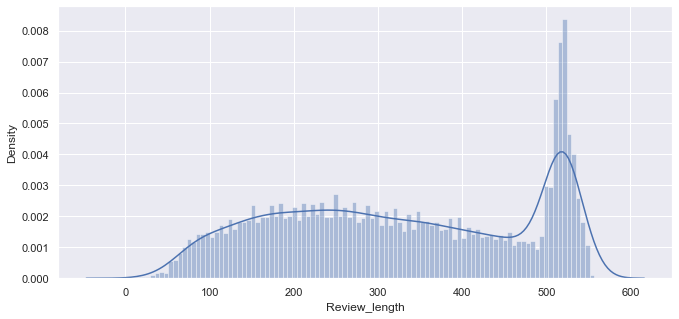

In [14]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

## Verificando o Tamanho do Texto da Avaliação com a Recomendação (Positiva/Negativa) <a class="anchor" id="eleventh-bullet"></a>

In [15]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

<AxesSubplot:ylabel='Density'>

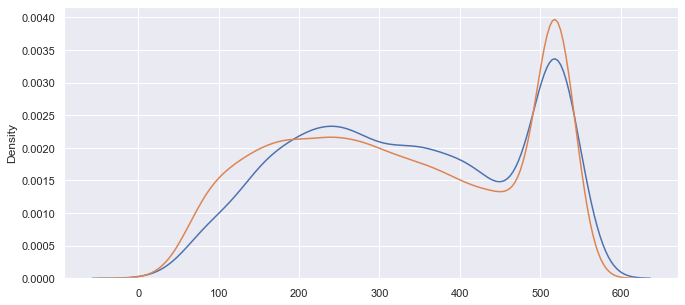

In [16]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

<b>Contando o Pontos de Exclamação das Avaliações</b>

In [17]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [18]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
0,1,Absolutely wonderful - silky and sexy and co...,55,0
1,1,Love this dress! it's sooo pretty. i happe...,305,1
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3


<b>Montando as Estatísticas das Exclamações Encontradas</b>

In [19]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    22641.000000
mean         0.860651
std          1.386701
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

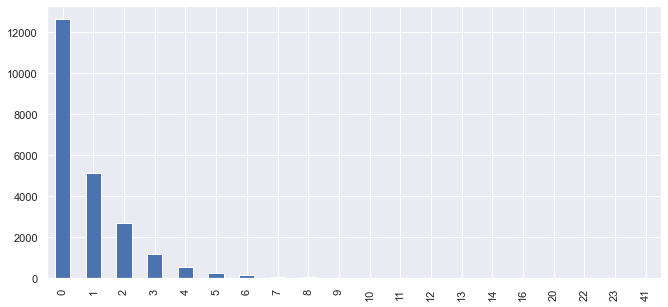

In [20]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [21]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

<b>Verificando a Avaliação com o Maior Número de Exclamações no Texto</b>

In [22]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

## Verificando Polaridade da Avaliação <a class="anchor" id="Twelfth-bullet"></a>

<b>A Polaridade é a emoção expessada em uma sentença. A Plaridade pode ser Positiva, Negativa ou Neutra. </b>
<br><b>A Polaridade possui uma pontuação que vai de -1.0 a 1.0 do tipo float. </b></br>

In [23]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
0,1,Absolutely wonderful - silky and sexy and co...,55,0,0.633333
1,1,Love this dress! it's sooo pretty. i happe...,305,1,0.339583
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891


<AxesSubplot:ylabel='Frequency'>

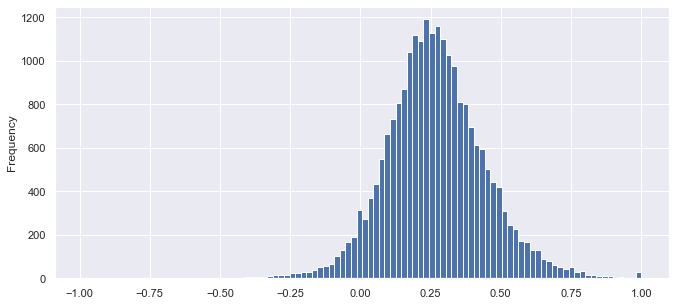

In [24]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [25]:
text_prep = text_df.copy()

## Processando o Texto da Avaliação <a class="anchor" id="Thirteenth-bullet"></a>

<b>Eliminando a pontuação do texto. </b>

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [28]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

0      Absolutely wonderful  silky and sexy and com...
1      Love this dress  its sooo pretty  i happened...
2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
Name: Review, dtype: object

## Verificando as Sentenças do Texto da Avaliação <a class="anchor" id="fourteenth-bullet"></a>

<b>Muitos Adjetivos e Verbos refletem uma avaliação positiva ou negativa.</b>


In [29]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=150)

In [30]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [31]:
text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

0                                wonderful comfortable
1    Love happened find im did have ordered online ...
2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
Name: Review, dtype: object

## Fazendo o Tratamento do Texto de Avaliação <a class="anchor" id="fifteenth-bullet"></a>

<b>Verificando todas as Stopwords, ou seja, palavras para serem ignoradas</b>

In [32]:
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


In [33]:
stop = stopwords.words('english')
stop.append("i'm")

<b>Removendo a Pontuação relacionada as Stopwords</b>

In [34]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


<b>Adicionado Stopwords relacionadas a roupas</b>

In [35]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [36]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [37]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)


<b>Verificando as avaliações após o Tratamento</b>

In [38]:
print(text_prep['Review'][3301])

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [39]:
print(text_prep['Review'][267]) 

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


<b>Removendo todo o texto relacionado à tamanho e números</b>

In [40]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [41]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

0                                wonderful comfortable
1    love happened find ordered online bc bought lo...
2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
Name: Review, dtype: object

In [42]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [43]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


<b>Derivando as Palavras</b>

In [44]:
porter = PorterStemmer()

In [45]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

0                             [wonderful, comfortable]
1    [love, happened, find, ordered, online, bc, bo...
2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
Name: Review, dtype: object

In [46]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [47]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

0                                    [wonder, comfort]
1    [love, happen, find, order, onlin, bc, bought,...
2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
Name: Review, dtype: object

In [48]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

0                                       wonder comfort
1    love happen find order onlin bc bought love hi...
2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
Name: Review, dtype: object

In [49]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


## Nuvem de Palavras das Avaliações Positivas e Negativas <a class="anchor" id="sixteenth-bullet"></a>

In [50]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
0,1,wonder comfort,55,0,0.633333
1,1,love happen find order onlin bc bought love hi...,305,1,0.339583
3,1,favorit love love fabul get great,141,3,0.560714


In [51]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

<b>Nuvem de Palavras das Avaliações Positivas</b>

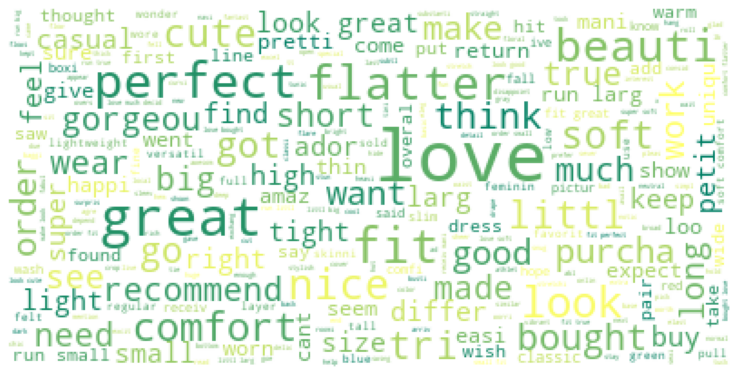

In [52]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<b>Nuvem de Palavras das Avaliações Negativas</b>

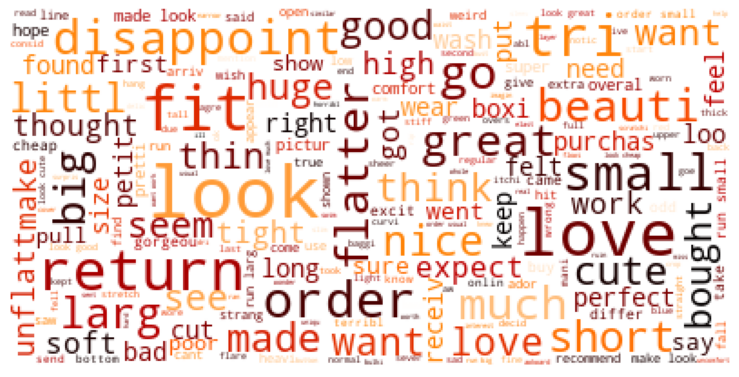

In [53]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Utilizando o Saco de Palavras <a class="anchor" id="seventeenth-bullet"></a>

<b> O modelo bag-of-words é uma representação simplificadora usada no processamento de linguagem natural. Nesse modelo, um texto (como uma frase ou um documento) é representado como a bolsa de suas palavras, desconsiderando a gramática e até mesmo a ordem das palavras, mas mantendo a multiplicidade.</b>

In [54]:
text_prep['Review'].head()

0                                       wonder comfort
1    love happen find order onlin bc bought love hi...
2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
Name: Review, dtype: object

In [55]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [56]:
bow_transformer = CountVectorizer()
bow_transformer.fit(text_prep['Review'])

CountVectorizer()

In [57]:
print(text_prep['Review'].iloc[3])

favorit love love fabul get great


In [58]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)
#3507=Love
#4438=petit

  (0, 2169)	1
  (0, 2231)	1
  (0, 2630)	1
  (0, 2750)	1
  (0, 3699)	2


In [59]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<22641x7669 sparse matrix of type '<class 'numpy.int64'>'
	with 265056 stored elements in Compressed Sparse Row format>

In [60]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (22641, 7669)
Amount of Non-Zero occurences: 265056


## TF-IDF <a class="anchor" id="eighteenth-bullet"></a>

<b>Term Frequency–Inverse Document Frequency</b>

In [61]:
Image(url= "https://miro.medium.com/max/1400/1*qQgnyPLDIkUmeZKN2_ZWbQ.png", width=600, height=200)

In [62]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)
#3507=Love
#4438=petit

  (0, 3699)	0.43616489465843045
  (0, 2750)	0.26326798744495516
  (0, 2630)	0.3601343007117292
  (0, 2231)	0.4957223310180473
  (0, 2169)	0.6041628980955307


In [63]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('legit', 3507)]

In [64]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('onlin', 4396),
 ('work', 7547),
 ('tight', 6711),
 ('due', 1881),
 ('shorten', 5672),
 ('gorgeou', 2700)]

In [65]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(22641, 7669)

In [66]:
print(messages_tfidf[:1]) 
#tuple(index_num, word_num), tfidf_proba

  (0, 7530)	0.860915186093191
  (0, 1207)	0.5087485059969477


## Mesclando a matriz esparsa com outros recursos <a class="anchor" id="nineteenth-bullet"></a>

In [67]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(22641, 7669)


,0,1,2,3,4,5,6,7,8,9,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214652,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [68]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
0,1,55,0,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1,305,1,0.339583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214652,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Dividindo os Dados <a class="anchor" id="twentieth-bullet"></a>

In [69]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
0,55,0,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,305,1,0.339583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214652,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [70]:
X.shape

(21819, 7672)

In [71]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
count,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,...,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000,21819.000000
mean,326.041386,0.860580,0.267154,0.000035,0.000022,0.000018,0.000016,0.000065,0.000016,0.000015,...,0.000019,0.000058,0.000063,0.000031,0.000062,0.000016,0.002114,0.000266,0.000022,0.000113
std,147.276319,1.388438,0.176592,0.003692,0.003312,0.002697,0.002398,0.005649,0.002348,0.002226,...,0.002798,0.004330,0.005497,0.004603,0.005341,0.002376,0.027143,0.010305,0.003310,0.006880
min,13.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201.000000,0.000000,0.157382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,319.000000,0.000000,0.260317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,478.000000,1.000000,0.373017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.405561,0.489153,0.398373,0.354255,0.600608,0.346865,0.328795,...,0.413308,0.385078,0.590839,0.679991,0.499605,0.351029,0.626986,0.585885,0.488954,0.530436


In [72]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15273, 7672), (6546, 7672), (15273,), (6546,))

In [73]:
y_train.value_counts(normalize=True)

1    0.819027
0    0.180973
Name: Recommended, dtype: float64

In [74]:
y_test.value_counts(normalize=True)

1    0.818973
0    0.181027
Name: Recommended, dtype: float64

## Utilizando o MinMax Scaler <a class="anchor" id="twenty-first-bullet"></a>

<b>Utilizando o scaler nos dados de treinamento. Significa que os dados de treinamento serão usados para estimar os valores mínimos e máximos observáveis.</b>

In [75]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
count,15273.000000,15273.000000,15273.000000,15273.000000,15273.0,15273.000000,15273.0,15273.000000,15273.000000,15273.000000,...,15273.0,15273.0,15273.000000,15273.0,15273.000000,15273.000000,15273.000000,15273.000000,15273.000000,15273.000000
mean,0.572427,0.020978,0.617947,0.000124,0.0,0.000065,0.0,0.000065,0.000065,0.000065,...,0.0,0.0,0.000109,0.0,0.000065,0.000065,0.003144,0.000446,0.000065,0.000185
std,0.271674,0.034138,0.092612,0.010881,0.0,0.008092,0.0,0.008092,0.008092,0.008092,...,0.0,0.0,0.009735,0.0,0.008092,0.008092,0.042774,0.017781,0.008092,0.013186
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.343808,0.000000,0.560503,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.558226,0.000000,0.614197,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.852126,0.024390,0.673239,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualização PCA <a class="anchor" id="twenty-second-bullet"></a>

<b>A Análise de Componentes Principais ou PCA (Principal Component Analysis) é uma técnica de análise multivariada que pode ser usada para analisar inter-relações entre um grande número de variáveis e explicar essas variáveis em termos de suas dimensões inerentes (Componentes)</b>

In [77]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.30403434, -0.07518546]])

<AxesSubplot:>

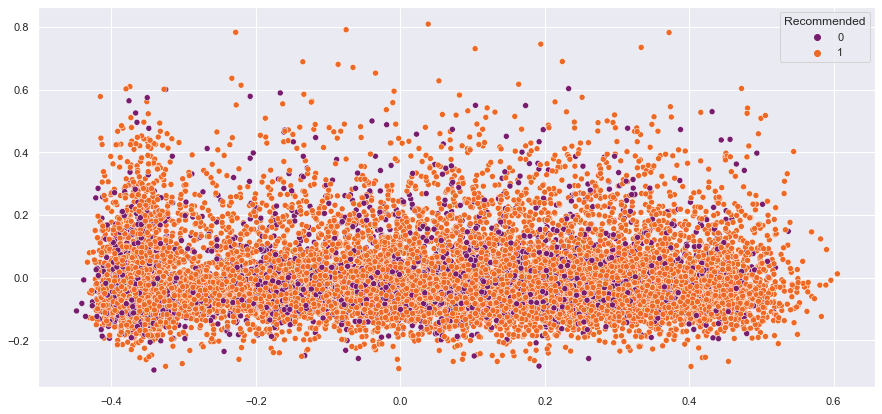

In [78]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [79]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<6546x7672 sparse matrix of type '<class 'numpy.float64'>'
	with 92230 stored elements in Compressed Sparse Row format>

## Modelos <a class="anchor" id="twenty-third-bullet"></a>

In [80]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

<b>A Avaliação do Modelo será feita por duas métricas:</b>

<br>F1 micro score - que é a média harmônica de precisão e recall, e leva em consideração os desequilíbrios de rótulo.</br>

<br>AUC - ROC é uma curva de probabilidade e AUC representa o grau ou medida de separabilidade. Ele informa o quanto o modelo é capaz de distinguir entre as classes.</br>

<b>1. Logistic Regression</b>

In [81]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [82]:
gs_lr_model.best_params_

{'C': 0.1}

In [83]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0   803   382
1  1469  3892

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.68      0.46      1185
           1       0.91      0.73      0.81      5361

    accuracy                           0.72      6546
   macro avg       0.63      0.70      0.64      6546
weighted avg       0.81      0.72      0.75      6546



<AxesSubplot:title={'center':'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

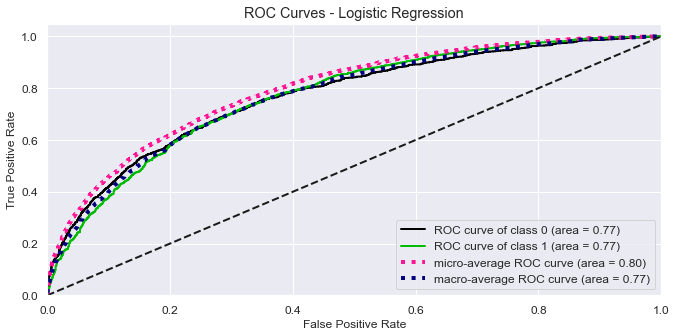

In [84]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression') 

<b>2. SVM</b>

In [85]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [86]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
      0     1
0   685   500
1  1374  3987

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.58      0.42      1185
           1       0.89      0.74      0.81      5361

    accuracy                           0.71      6546
   macro avg       0.61      0.66      0.62      6546
weighted avg       0.79      0.71      0.74      6546



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

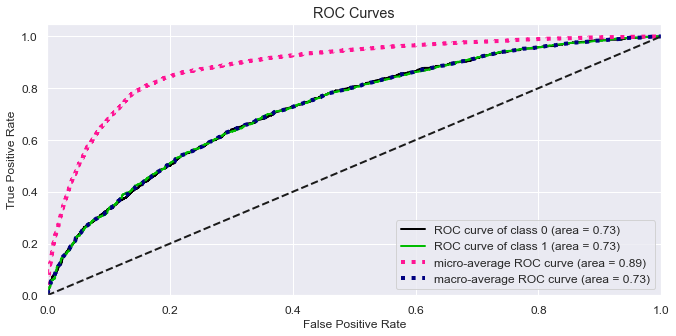

In [87]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

<b>3. Random Forest</b>

In [88]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

In [89]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
      0     1
0   743   442
1  1243  4118

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.63      0.47      1185
           1       0.90      0.77      0.83      5361

    accuracy                           0.74      6546
   macro avg       0.64      0.70      0.65      6546
weighted avg       0.81      0.74      0.76      6546



<AxesSubplot:title={'center':'ROC Curves - Random Forest'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

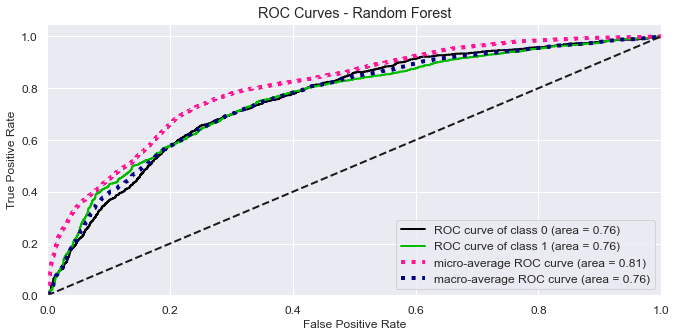

In [90]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 

In [91]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(0.0719743075690777, 'Polarity'),
 (0.04108884824763568, 'count_exc'),
 (0.024867569383226092, 'Review_length'),
 (0.011255329815408487, 79),
 (0.009796167479568215, 2630),
 (0.008017978812729322, 2713),
 (0.0075692285111771, 2297)]

In [92]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0113   Word num: 79   Word:  ador
Importance: 0.0098   Word num: 2630   Word:  get
Importance: 0.0080   Word num: 2713   Word:  got
Importance: 0.0076   Word num: 2297   Word:  fine
Importance: 0.0074   Word num: 5897   Word:  small
Importance: 0.0074   Word num: 124   Word:  airi
Importance: 0.0073   Word num: 3466   Word:  layer
Importance: 0.0068   Word num: 5159   Word:  regular
Importance: 0.0068   Word num: 2231   Word:  favorit
Importance: 0.0067   Word num: 4044   Word:  move
Importance: 0.0063   Word num: 6291   Word:  stripe
Importance: 0.0061   Word num: 591   Word:  big
Importance: 0.0060   Word num: 3699   Word:  love
Importance: 0.0058   Word num: 6360   Word:  suggest
Importance: 0.0057   Word num: 3472   Word:  lb
Importance: 0.0056   Word num: 2363   Word:  flatter
Importance: 0.0055   Word num: 2246   Word:  feel
Importance: 0.0051   Word num: 5276   Word:  return


<b>Random Forest - Threshold:</b>

In [93]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

Text(0, 0.5, 'TPR')

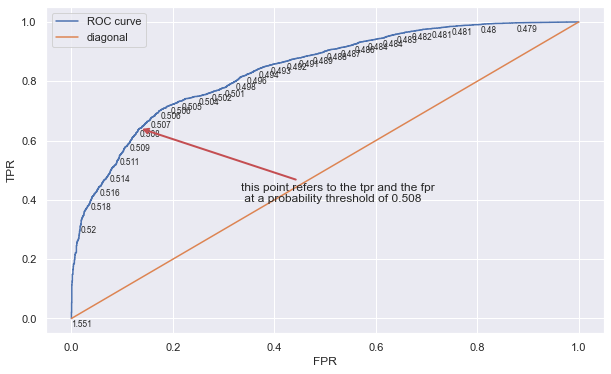

In [94]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [95]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

Text(0, 0.5, 'TPR')

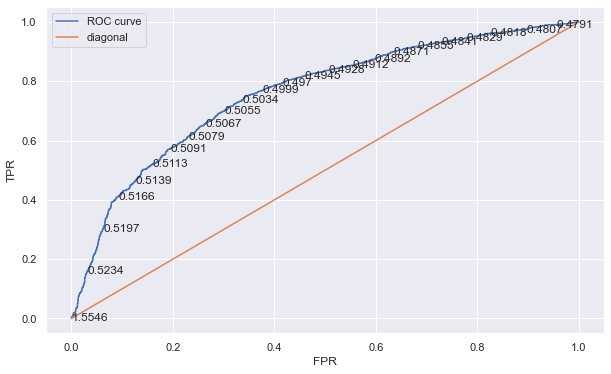

In [96]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

<b>4. AdaBoost</b>

In [97]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=5,
                                                         random_state=555),
                   learning_rate=0.001, n_estimators=1000, random_state=222)

In [98]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))

Confusion Matrix:
      0     1
0   718   467
1  1179  4182

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.61      0.47      1185
           1       0.90      0.78      0.84      5361

    accuracy                           0.75      6546
   macro avg       0.64      0.69      0.65      6546
weighted avg       0.81      0.75      0.77      6546



<AxesSubplot:title={'center':'ROC Curves - AdaBoost'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

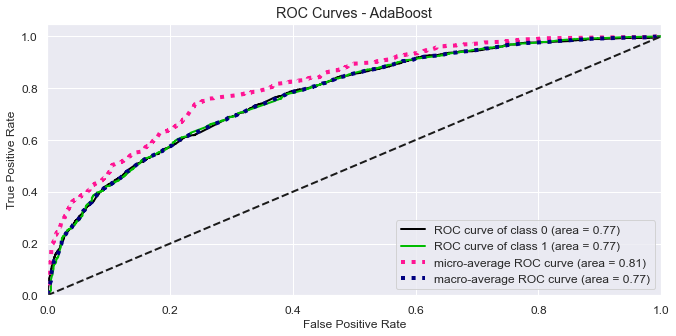

In [99]:
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

## Resultados <a class="anchor" id="twenty-fourth-bullet"></a>

<b>
* Logistic Regression - 0.72
<br>* SVM - 0.72</br>
<br>* Random Forest - 0.76</br>
<br>* AdaBoost - 0.74 </br>   
</b>

In [100]:
labels = text_prep['Recommended']
train_set=text_prep['Review']
tf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True, use_idf=True)
features = tf_vectorizer.fit_transform(text_prep['Review'])
svc_model.fit(features,labels)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [101]:

recommendation_text = widgets.Text(
  description='Recommendation:',
  placeholder='Write a recommendation'
)
btn_predict = widgets.Button(
  description='Verificar',
  disabled=False,
  tooltip='Verifique aqui...',
  button_style='success', # pode ser 'success', 'info', 'warning', 'danger' ou ''
  icon='check'
)
box_result = widgets.Box(
  [
    widgets.HTML(
        value= f"<span style='font-size:2.3em; color:blue'>Resultado: </span>"
                 ),
    widgets.HTML(
        value=f"<span style='font-size:2.3em'>\U00002796</span>"
        )
  ]
)
teste = widgets.Label(
  value='---'
)
display(recommendation_text,btn_predict,box_result,teste)

def prediction_query(s):
    word_find = False
    box_result.children[1].value =f"<span style='font-size:2.3em'>\U00002796</span>"
    text_pred= recommendation_text.value
    #Eliminar pontuações
    punct = string.punctuation
    for c in punct:
        text_pred = text_pred.replace(c, "")
    text_pred = text_pred.split()
    #Eliminar stopwords 
    text_pred = [word for word in text_pred if word not in stopwords.words('english')]
    #Eliminar números
    text_pred = [i for i in text_pred if not i.isdigit()]
    text_neg = neg_words.split()
    text_pos = pos_words.split()
    for a in text_pred:
        for b in text_neg:
            if a==b:
                word_find = True
    for x in text_pred:
        for y in text_pos:
            if x == y :
                word_find = True
    if word_find == True:
        vector_recommendation = tf_vectorizer.transform([recommendation_text.value])
        prediction = svc_model.predict(vector_recommendation)
        if prediction == 1:
            box_result.children[1].value = f"<span style='font-size:2.3em'>\U0001f600</span>"
        else:
            box_result.children[1].value = f"<span style='font-size:2.3em'>\U0001F61E</span>"
    teste.value = str(text_pred)
btn_predict.on_click(prediction_query)

Text(value='', description='Recommendation:', placeholder='Write a recommendation')

Button(button_style='success', description='Verificar', icon='check', style=ButtonStyle(), tooltip='Verifique …

Box(children=(HTML(value="<span style='font-size:2.3em; color:blue'>Resultado: </span>"), HTML(value="<span st…

Label(value='---')